##### Q-Learning on Hexapawn

This notebook walks through the **RL components** and trains a Q-learning agent on Hexapawn. Use the project’s `.venv` as the kernel.

**Components:** Environment (MDP), Agent (Q-table, ε-greedy, update), Training (episodes), and a **step-by-step simulation** you can advance one move at a time.

In [1]:
import pandas as pd

from hexapawn.environment import HexapawnEnv
from hexapawn.agent import QLearningAgent
from hexapawn.training import train, run_episode, simulate_step_by_step
from hexapawn.state import state_to_string, initial_state
from hexapawn.actions import legal_actions, apply_action

##### 1. Inspect state and actions

In [2]:
state = initial_state()
print("Initial board (W=white, B=black):")
print(state_to_string(state))
print("Legal moves for White:", legal_actions(state))

Initial board (W=white, B=black):
W W W
. . .
B B B
Turn: White
Legal moves for White: [(0, 0, 1, 0), (0, 1, 1, 1), (0, 2, 1, 2)]


##### 2. Create environment and agent

In [4]:
env = HexapawnEnv(agent_side=1, seed=42)  # 1 = White
agent = QLearningAgent(alpha=0.1, # Tasa de aprendizaje
                        gamma=0.99, # Factor de descuento
                        epsilon=0.2, # Exploración vs Explotación (ε-greedy)
                        seed=42
                        )

##### 3. Train and record evaluation returns

In [6]:
num_episodes = 3000 # Un episodio = el agente juega una partida completa desde el inicio hasta terminar (ganar, perder o alcanzar límite de pasos).
eval_every = 300 # Cada cuántos episodios se mide el rendimiento del agente.
num_eval = 50 # Cuando toca evaluar, el agente juega 50 partidas de prueba (sin aprender) y se promedia el retorno obtenido para medir qué tan bueno es en ese momento.

eval_returns = train(
    env, agent, num_episodes,
    eval_every=eval_every,
    num_eval_episodes=num_eval,
)

df = pd.DataFrame({
    "episode": [eval_every * (i + 1) for i in range(len(eval_returns))],
    "avg_return": eval_returns,
})
df

,episode,avg_return
0,300,0.84
1,600,0.76
2,900,0.84
3,1200,0.68
4,1500,0.80
5,1800,0.88
6,2100,0.68
7,2400,0.80
8,2700,0.72
9,3000,0.84


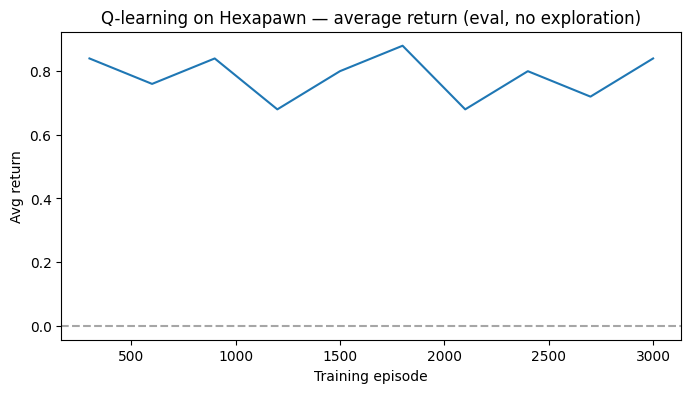

In [7]:
ax = df.set_index("episode")["avg_return"].plot(
    title="Q-learning on Hexapawn — average return (eval, no exploration)",
    xlabel="Training episode",
    ylabel="Avg return",
    figsize=(8, 4),
)
ax.axhline(y=0, color="gray", linestyle="--", alpha=0.7)

### 6. Q-table size and final performance

In [8]:
print(f"States in Q-table: {agent.num_states()}")
print(f"Final eval average return (last {num_eval} episodes): {eval_returns[-1]:.3f}")

States in Q-table: 89
Final eval average return (last 50 episodes): 0.840


### 7. Step-by-step simulation

Create a simulation, then **re-run the "Advance one move" cell** to see each move. Every move is shown one at a time: **state (who to move) → action → next state (other side to move)**. The next state becomes the state for the following move, so there are no jumps. You see agent and opponent moves in order. When the game ends, re-run the "Create simulation" cell to start a new game. **re-run the “Advance one step” cell** to see each move. When the episode ends, re-run the "Create simulation" cell to start a new game. We use **no fixed seed** here so each new simulation is a different game (and possibly different length); with a fixed seed you would see the same game every time.

In [9]:
# Create a new simulation (no seed = different game each time; use seed=42 for same game every time)
sim_env = HexapawnEnv(agent_side=1, seed=None)
sim_agent = QLearningAgent(alpha=0.1, gamma=0.99, epsilon=0.0, seed=None)  # epsilon=0 for greedy
# Option: use the trained agent instead: sim_agent = agent
sim = simulate_step_by_step(sim_env, sim_agent, train=False)

In [56]:
# Advance one move. Re-run to see: State (Player X) → Action (Player X) → State (Player Y).
# Agent = Player 1 (White), Opponent = Player 2 (Black). Re-run "Create simulation" if you get unpack errors.
try:
    result = next(sim)
    if len(result) == 6:
        state, action, next_state, reward, done, is_agent = result
    else:
        state, action, reward, done = result[0], result[1], result[2], result[4]
        is_agent = True
        next_state = apply_action(state, action)  # old format: show state after this move only
    # Player 1 = White (1), Player 2 = Black (-1)
    p1 = "Player 1 (White)"
    p2 = "Player 2 (Black)"
    who = p1 if state[1] == 1 else p2
    who_next = p1 if next_state[1] == 1 else p2
    print(f"State — {who} to move:")
    print(state_to_string(state))
    print(f"\n{who} plays:", action)
    print("Reward:", reward, "| Done:", done)
    print(f"\nState — {who_next} to move (after the move above):")
    print(state_to_string(next_state))
except StopIteration:
    print("Simulation ended. Re-run the previous cell to start a new game.")
except NameError:
    print("Run the previous cell first to create the simulation (sim).")

State (White to move):
W W .
. . B
B . B
Turn: White

Agent plays: (0, 1, 1, 1)
Reward: 0.0 | Done: False

Next state (White to move):
W . .
. B B
. . B
Turn: White
